# Routines for extracting the geometries of tracks (angle, length)

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from analysis_funcs import *

In [3]:
def extract_track(obs, ii):
    """
    Extract and reshape a track from TrackObs obs at index ii.
    Output track is in units of electrons
    """
    return np.reshape(obs.data[ii]["TRACK"],(obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))*obs.gain

In [4]:
### Routines using Hough transformation

def unbin(track, fac_AL, fac_AC):
    """
    Resample the track onto a grid of quadratic pixels.
    fac_AL and fac_AC relate the length of AL and AC samples to 10 um 
    (so usually fac_AL = bin_AL, fac_AC = 3*bin_AC)
    """
    outimg = np.zeros((track.shape[0]*fac_AL, track.shape[1]*fac_AC))
    rescale = track/(fac_AL * fac_AC)
    
    for iAL in range(track.shape[0]):
        for iAC in range(track.shape[1]):
            if rescale[iAL,iAC] != 0:
                outimg[iAL*fac_AL:(iAL+1)*fac_AL, iAC*fac_AC:(iAC+1)*fac_AC] = rescale[iAL,iAC]
    return outimg

def get_angle_hough(unbinned):
    from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

    h, th, d = hough_line(unbinned)
    theta = hough_line_peaks(h, th, d)[1][0] # this should be chosen differently
    #return theta
    return hough_line_peaks(h, th, d)[1]

In [5]:
def linefunc_m(pars, x):
    """
    pars is an array of [slope,y0], the equation being slope*x + y0
    """
    return pars[0]*x + pars[1]

def angle_linefit_m(intrack, pixratio=1):
    """
    Determine the angle of the track with respect to axis 0.
    In case of non-quadratic pixels, pixratio gives the ratio of pixel lengths in axis 1 to axis 0 
    (so in case of Gaia, AC/AL including binnning)
    """
    # the input track may have some rows/colums with zero values
    # remove those
    goodx = np.max(intrack,axis=1)>0
    goody = np.max(intrack,axis=0)>0
    track = intrack[np.where(goodx)[0],:]
    track = track[:,np.where(goody)[0]]
    
    dim0, dim1 = track.shape
    
    # We will form an x/y value pairs, with x being along axis 0, y being along axis 1
    # the values of the longer axis (i.e. more pixels) will just be the pixel coordinates
    # the values of the shorter axis will be the center of mass for each row/column
    
    from scipy.ndimage.measurements import center_of_mass
    
    if dim0 >= dim1:
        labels = np.zeros((dim0,dim1)) + np.transpose(np.array([range(dim0)]))
        cms = (center_of_mass(track, labels, range(dim0)))              
    else:
        labels = np.zeros((dim0,dim1)) + np.array([range(dim1)])
        cms = (center_of_mass(track, labels, range(dim1)))
        
    # set x and y from the centers of mass and subtract offset so the middle value is (0,0)
    x = (np.array([c[0] for c in cms]) - (dim0-1)/2)
    y = (np.array([c[1] for c in cms]) - (dim1-1)/2)* pixratio
    
    # TODO erros should be calculated more intelligently
    dx = np.zeros(x.shape)+0.5
    dy = np.zeros(y.shape)+pixratio/2
    
    # Estimation of the angle and the length
    
    # We give special treatment to 1-dimensional tracks
    # We will also consider a dimension to be 1 if the difference between endpoints is very small.
    # This could be, for instance, because some additional noise has been picked up, 
    # which will be absorbed by the center of mass
    if dim1==1 or np.abs(y[-1]-y[0])<pixratio/2:
        ## Angle
        # 0 degrees
        theta = 0
        #sd_theta = np.arctan(dy[0]/(dim0*dx[0]))*180/np.pi
        sd_theta = np.arctan(pixratio/dim0)*180/np.pi
        
        ## Length
        # the longest possible track goes between the most distant corners
        longlen = np.sqrt(dim0**2 + pixratio**2)
        # the shortest possible track goes between the nearest pixel borders
        shortlen = dim0-2
        # let's calculate the measured length as the mean of the two
        tracklen = (shortlen+longlen)/2
        sd_tracklen = np.abs(longlen-shortlen)/2
        
    elif dim0==1 or np.abs(x[-1]-x[0])<1/2:
        ## Angle
        # +-90
        # if x points in a particular direction, choose that one
        tsign = np.sign(x[-1]-x[0])
        if tsign == 0:
            tsign = 1
            
        theta = 90 * tsign
        #sd_theta = np.abs(theta-np.arctan((dim1*dy[0])/dx[0])*180/np.pi)
        sd_theta = np.abs(theta - np.arctan((dim1*pixratio)) * 180/np.pi * tsign )
        
        ## Length
        # the longest possible track goes between the most distant corners
        longlen = np.sqrt((pixratio*dim1)**2 + 1)
        # the shortest possible track goes between the nearest pixel borders
        shortlen = pixratio*(dim1-2)
        # let's calculate the measured length as the mean of the two
        tracklen = (shortlen+longlen)/2
        sd_tracklen = np.abs(longlen-shortlen)/2
              
    else:
        ## Angle
        # get the slope via a fit

        from scipy import odr

        linemodel = odr.Model(linefunc_m)

        fitdat = odr.RealData(x, y, sx=dx, sy=dy)

        # give a rough starting value for theta
        slopestart = (y[-1]-y[0])/(max([x[-1]-x[0],1]))
        
        myodr = odr.ODR(fitdat, linemodel, beta0=[slopestart, 0.])
        myoutput = myodr.run()
        slope = myoutput.beta[0]
        sd_slope = myoutput.sd_beta[0]
        
        theta = np.arctan(slope) * 180/np.pi
        sd_theta = sd_slope/(1+slope**2) * 180/np.pi

        ## Length
        # pre-compute some exponents of the slope
        slope2 = slope**2
        slope4 = slope**4
        slope6 = slope**6
        # depending on which axis was used to fit, calculate the length differently
        if dim0>=dim1:
            tracklen = np.abs(x[-1]-x[0]) * np.sqrt(slope2+1)
            sd_tracklen = np.sqrt((slope2+1) * (dx[-1]**2+dx[0]**2)
                                  + (x[-1]-x[0])**2 * (slope2/(1+slope2)) * sd_slope**2)
        else:
            tracklen = np.abs(y[-1]-y[0]) * np.sqrt(1+1/slope2)
            sd_tracklen = np.sqrt((1+1/slope2) * (dy[-1]**2+dy[0]**2)
                                  + (y[-1]-y[0])**2 * 1/(slope4 + slope6)  * sd_slope**2)

            
    return theta, sd_theta, np.abs(tracklen), sd_tracklen

# Choosing source and time ranges

In [7]:
import glob

In [29]:
# SM
bin_AL = 2
bin_AC = 2
pixdepth = 12  # depletion zone depth in mum

obslist = []
#for l in glob.glob('../output/SM/2015/08/0*/*.fits')+glob.glob('../output/SM/2015/08/1*/*.fits'):
for l in sorted(glob.glob('../output/SM/2016/02/*/*.fits')):
#for l in sorted(glob.glob('../output/SM/2017/04/*/*.fits')+glob.glob('../output/SM/2017/05/*/*.fits')+glob.glob('../output/SM/2017/06/*/*.fits')):
    obslist += read_Obslist_fits(l)
    

#obslist = read_Obslist_fits('../output/SM/2015/10/29/SM-SIF_OBMT_START_63088020999741500.fits') # smaller flare
#obslist = read_Obslist_fits('../output/SM/2017/09/10/SM-SIF_OBMT_START_122020498000375100.fits') # big flare
#obslist = read_Obslist_fits('../output/SM/2017/09/11/SM-SIF_OBMT_START_122099767998746300.fits') # big flare tail




# BAM
#bin_AL = 1
#bin_AC = 4
#pixdepth = 38  # depletion zone depth in mum

#obslist = read_Obslist_fits('../analysis/bam/output/2017-07-03/BAM-OBS1_OBMT_START_115999323050548704.fits')
#obslist = read_Obslist_fits('../output/BAM/2014/09/03/BAM-OBS1_OBMT_START_26728722356619500.fits') # flare
#obslist = read_Obslist_fits('../output/BAM/2014/09/11/BAM-OBS1_OBMT_START_27411485143143500.fits') # flare
#obslist = read_Obslist_fits('../output/BAM/2015/10/29/BAM-OBS1_OBMT_START_63098908549541904.fits') # flare
#obslist = read_Obslist_fits('../output/BAM/2015/10/31/BAM-OBS1_OBMT_START_63263255156693904.fits')  # quiet
#obslist = read_Obslist_fits('../output/BAM/2017/09/14/BAM-OBS1_OBMT_START_122433475209019104.fits')

#obslist = read_Obslist_fits('../output/BAM/2017/09/10/BAM-OBS1_OBMT_START_122046338760775104.fits') # before big flare
#obslist = read_Obslist_fits('../output/BAM/2017/09/10/BAM-OBS1_OBMT_START_122069857164775104.fits')[200:300] # onset of big flare
#obslist = read_Obslist_fits('../output/BAM/2017/09/12/BAM-OBS1_OBMT_START_122210403147079104.fits')[400:500] # tail of big flare

## full revolutions in BAM
# big flare tail
#obslist = read_Obslist_fits('../output/BAM/2017/09/12/BAM-OBS1_OBMT_START_122186884743079104.fits') + read_Obslist_fits('../output/BAM/2017/09/12/BAM-OBS1_OBMT_START_122198643945079104.fits')
#obslist = read_Obslist_fits('../output/BAM/2017/09/12/BAM-OBS2_OBMT_START_122186884736199504.fits') + read_Obslist_fits('../output/BAM/2017/09/12/BAM-OBS2_OBMT_START_122198643938199504.fits')
#obslist = obslist[:940]
# quiet time
#obslist = read_Obslist_fits('../output/BAM/2015/10/31/BAM-OBS1_OBMT_START_63322239313925904.fits') + read_Obslist_fits('../output/BAM/2015/10/31/BAM-OBS1_OBMT_START_63334069071137904.fits')
#obslist = read_Obslist_fits('../output/BAM/2015/10/31/BAM-OBS2_OBMT_START_63322051159814304.fits') + read_Obslist_fits('../output/BAM/2015/10/31/BAM-OBS1_OBMT_START_63334069071137904.fits')
#obslist = obslist[:940]



# BAM-SIF
#bin_AL = 1
#bin_AC = 4
#pixdepth = 38  # depletion zone depth in mum

#obslist = []
#for l in sorted(glob.glob('../output/BAM-SIF/20*/*/*/*.fits')):
#    obslist += read_Obslist_fits(l)    
#obslist = [o for o in obslist if o.fov==2]


print('Nr. Observations:',len(obslist))

Nr. Observations: 279


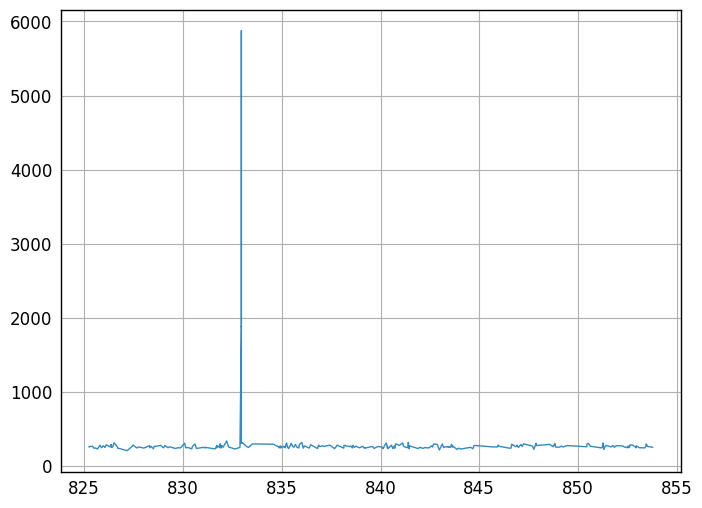

In [30]:
#out = fits_flux(sorted(glob.glob('../output/SM/2017/04/*/*.fits')+glob.glob('../output/SM/2017/05/*/*.fits')+glob.glob('../output/SM/2017/06/*/*.fits')))
#out = fits_flux(['../output/BAM/2015/10/29/BAM-OBS1_OBMT_START_63098908549541904.fits'])

#plt.plot(out[0],out[2])
#print(len(out[0]))


plt.plot([o.acqTime/1e9/24/3600 for o in obslist], [len(obs.data) for obs in obslist])

In [31]:
sorted(glob.glob('../output/BAM/2014/09/11/BAM-OBS1*.fits'))

['../output/BAM/2014/09/11/BAM-OBS1_OBMT_START_27411485143143500.fits',
 '../output/BAM/2014/09/11/BAM-OBS1_OBMT_START_27423244345143500.fits',
 '../output/BAM/2014/09/11/BAM-OBS1_OBMT_START_27435027065547500.fits',
 '../output/BAM/2014/09/11/BAM-OBS1_OBMT_START_27446786267547500.fits',
 '../output/BAM/2014/09/11/BAM-OBS1_OBMT_START_27458545469547500.fits',
 '../output/BAM/2014/09/11/BAM-OBS1_OBMT_START_27470304671547500.fits',
 '../output/BAM/2014/09/11/BAM-OBS1_OBMT_START_27473479656087500.fits',
 '../output/BAM/2014/09/11/BAM-OBS1_OBMT_START_27485262376491500.fits']

In [34]:
bigtracks = []

for obs in obslist:   
    for ii in range(len(obs.data)):
        track = extract_track(obs,ii)
        #if np.sum(track>0) < 5 or np.sum(track>0)>1000:
        #if (track.shape[0]<cutoffs[0] and track.shape[1]<cutoffs[1]) or np.sum(track>0)>1000:
        if np.sum(track>0)>1000:
            print("Row {}, FOV {}".format(obs.row, obs.fov))
            print(obs.data["LOC_AL"][ii],obs.data["LOC_AC"][ii])
            print(track.shape)
            bigtracks.append(track)

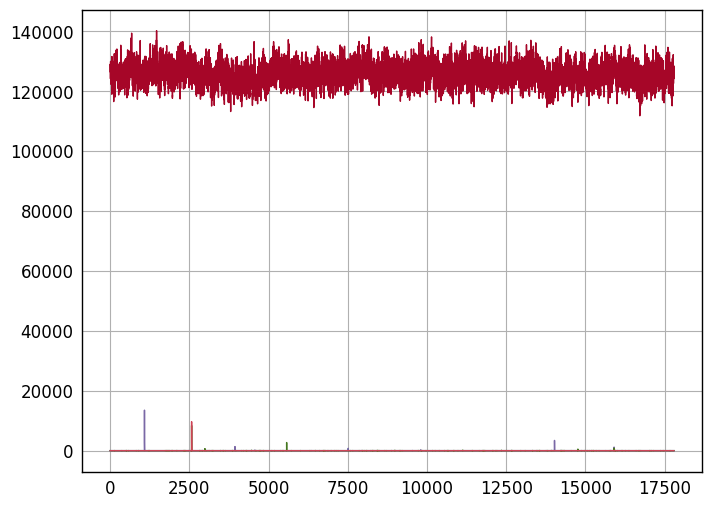

In [23]:
plt.plot(bigtracks[5])

# single example

In [148]:
longobs = []

for ii in range(len(obslist)):
    if (len(obslist[ii].data) == 0):
        continue
    trackpix = np.array([np.sum(t>0) for t in obslist[ii].data['TRACK']])
    valids = np.max(trackpix)
    if valids >=10:
    #if valids >=40:
        longobs.append(ii)

print('Nr. interesting observations:', len(longobs))

Nr. interesting observations: 940


In [149]:
iobs = longobs[24] # 2 for AL>AC, 

#itrack = np.argmax(np.sqrt((20*obslist[iobs].data['DIM_AL'])**2 + (60*obslist[iobs].data['DIM_AC'])**2))
#itrack = np.argmax(obslist[iobs].data['DIM_AL'])
itrack = np.argmax([np.sum(t>0) for t in obslist[iobs].data['TRACK']])

print("Nr. of samples:",np.sum(obslist[iobs].data[itrack]['TRACK']>0))

Nr. of samples: 31


Track Energy: 35456
Per pixel: 1143.74193548


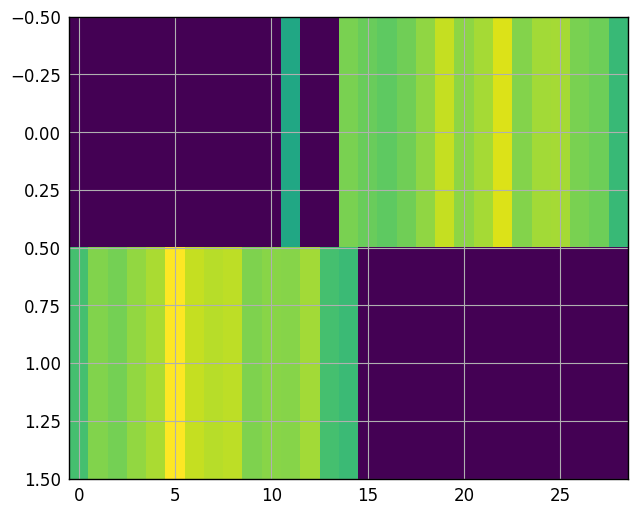

In [150]:
# view the track

track = (extract_track(obslist[iobs], itrack))

#plt.imshow(np.flip(np.rot90(track+1),1), norm=LogNorm())
plt.imshow(np.rot90(track+1), norm=LogNorm(), aspect=3*bin_AC/bin_AL)

print("Track Energy:", obslist[iobs].data[itrack]['TRACK_EN'])
print("Per pixel:", obslist[iobs].data[itrack]['TRACK_EN']/np.sum(obslist[iobs].data[itrack]['TRACK']>0))

In [151]:
angle_linefit_m(track,3*bin_AC/bin_AL)

(31.749868988071285,
 2.6389387606022354,
 32.927485290825942,
 1.2538808236356698)

# test for everything

In [152]:
theta = []
sd_theta = []
length = []
sd_length = []
energies = []

badtracks = []

#cutoffs = (6,3)
#cutoffs = (10,10)
import time

t0 = time.time()
for obs in obslist:   
    for ii in range(len(obs.data)):
        track = extract_track(obs,ii)
        #if np.sum(track>0) < 5 or np.sum(track>0)>1000:
        #if (track.shape[0]<cutoffs[0] and track.shape[1]<cutoffs[1]) or np.sum(track>0)>1000:
        if ( np.sum(track>0) < 5 or np.sum(track>0)>1000
        or (track.shape[0]==2 and track.shape[1]<4) 
        or (track.shape[1]==2 and track.shape[0]<np.max([3*bin_AC/bin_AL, 5])) ):
            continue # too few values to process or an obvious outlier
        ang,sd_ang,l,sd_l = angle_linefit_m(track,pixratio=3*bin_AC/bin_AL)
        while ang>90:
            ang -= 180
        while ang<-90:
            ang += 180
        theta.append(ang)
        sd_theta.append(sd_ang)
        length.append(l*10*bin_AL)
        sd_length.append(sd_l*10*bin_AL)
        energies.append(obs.data['TRACK_EN'][ii])
        if sd_ang==0:
            badtracks.append(extract_track(obs,ii))  
        
theta = np.array(theta)
sd_theta = np.array(sd_theta)
length = np.array(length)
sd_length = np.array(sd_length)
energies = np.array(energies)

print("Processing took", time.time()-t0, 's')

nparticles = np.sum([len(o.data) for o in obslist])
print("Using {} of {} particles ({} %)".format(len(theta),nparticles,len(theta)/nparticles*100))

Processing took 7.812258958816528 s
Using 15011 of 63927 particles (23.481471052919737 %)


In [153]:
len(badtracks)

0

# Histograms

(-90, 90)

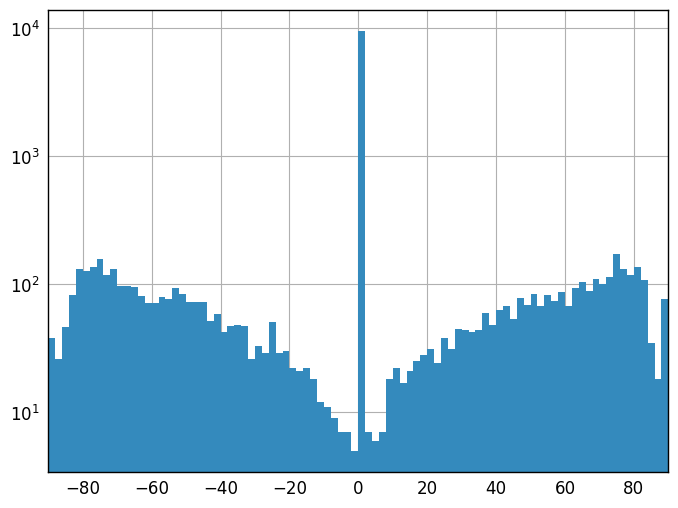

In [154]:
testhist = plt.hist(theta, 90, range=(-90,90),log=True)
plt.xlim(-90,90)
#plt.ylim(0,4e2)

(-90, 90)

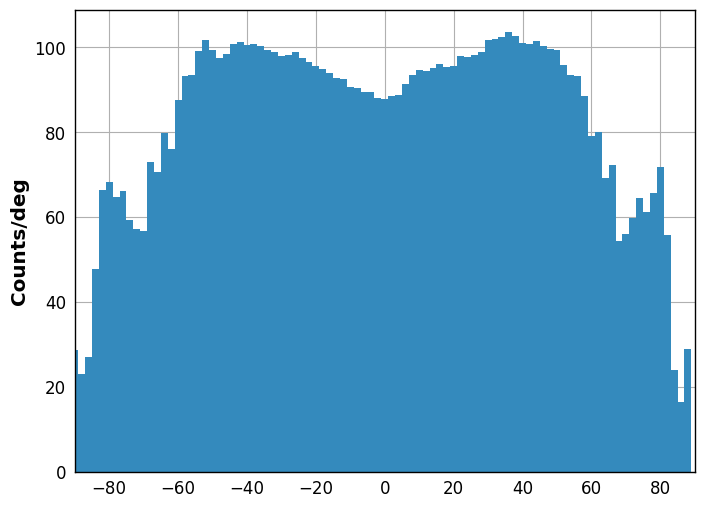

In [155]:
# an angular histogram that spreads each angle out according to its error

nbins = 90
bin_lo = np.linspace(-90,90,nbins,endpoint=False)
vals = np.zeros(len(bin_lo))
bin_width = bin_lo[1]-bin_lo[0]

minvals = theta-sd_theta
maxvals = theta+sd_theta

minvals = minvals[sd_theta>0]
maxvals = maxvals[sd_theta>0]

for ii in range(len(minvals)):
    add_range = np.logical_and(bin_lo+bin_width >= minvals[ii], bin_lo <= maxvals[ii])
    if maxvals[ii] > 90:
        add_range += bin_lo <= maxvals[ii]-180
    if minvals[ii] < -90:
        add_range += bin_lo+bin_width >= minvals[ii]+180
    
    vals[add_range] += 1/np.sum(add_range)

    
norm = bin_width
plt.bar(bin_lo, vals/norm, width=bin_width,log=False)
plt.ylabel("Counts/deg")
plt.xlim(-90,90)
#plt.ylim(0,1400)

Two components here: The high and frequent ones with regular spacing are particles with dim_AC = 1 (manual uncertainty calc.)

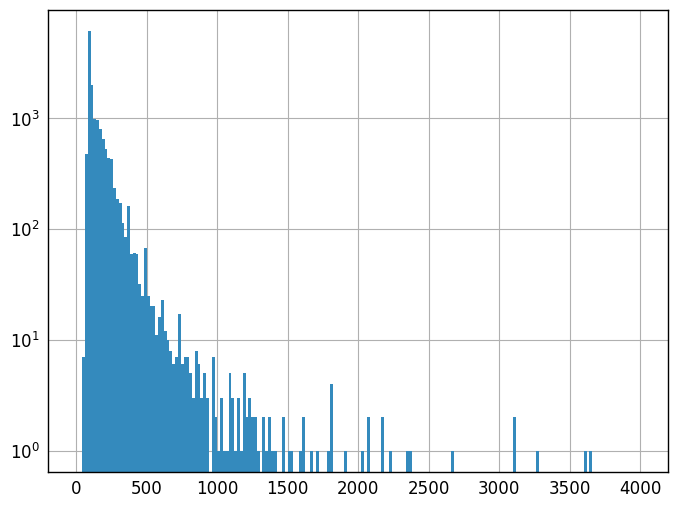

In [156]:
testhist = plt.hist(length, 200,log=True,range=(0,4000))

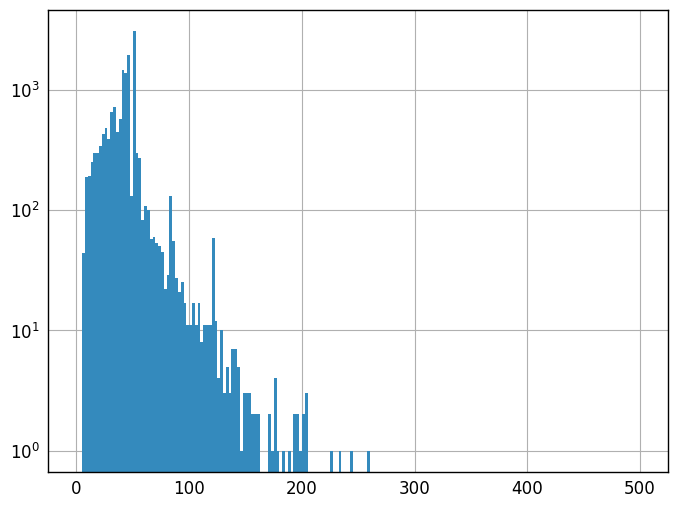

In [157]:
testhist = plt.hist(sd_length, 200,log=True,range=(0,500))

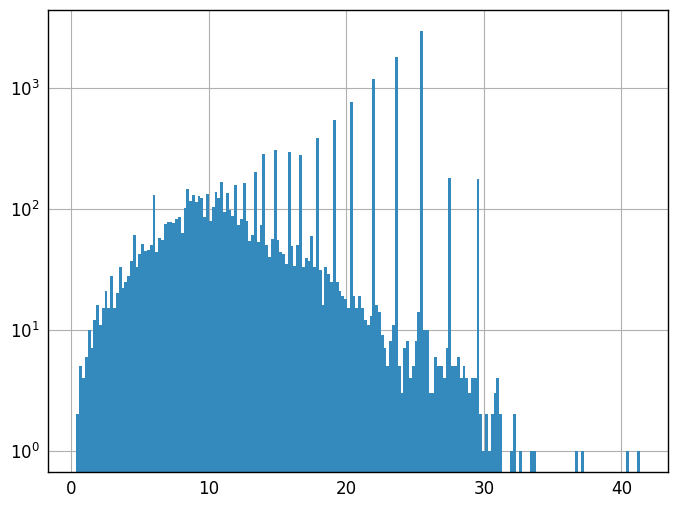

In [158]:
alpha_entr = np.arctan(pixdepth/length)*180/np.pi
athist = plt.hist(alpha_entr, 200,log=True)

(-500, 10000)

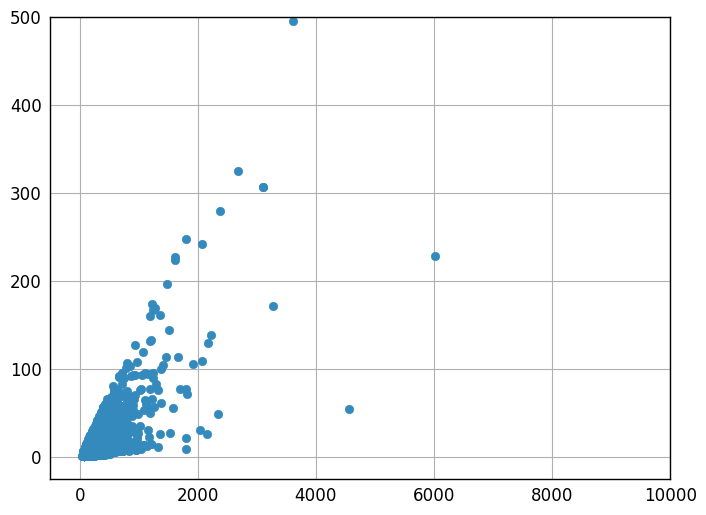

In [159]:
plt.scatter(length,length/sd_length)
plt.ylim((-25,500))
plt.xlim((-500,10000))

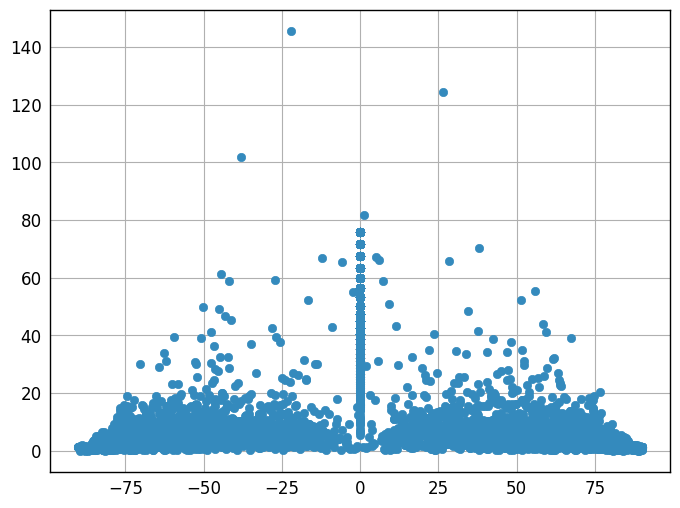

In [160]:
plt.scatter(theta,sd_theta)
#plt.ylim(-5,95)

# Angular histogram (Nr. of cosmic per angle)

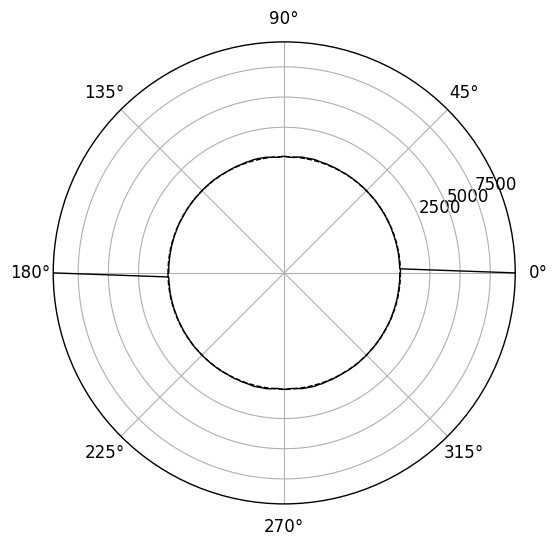

In [161]:
theta_binning = np.copy(theta)
theta_binning[theta<0] += 180
#theta_binning +=sd_theta*(2*np.random.random(theta.shape)-1)

alpha = np.linspace(0,180,90)
radocc = np.zeros(alpha.shape[0])
da = alpha[1]-alpha[0]
bin_lo = alpha-da/2


for ii in range(len(alpha)):
    bin_indices = np.logical_and(theta_binning>=bin_lo[ii], theta_binning<=bin_lo[ii]+da)
    # let's also introduce a length filter
    radocc[ii] = np.sum(np.logical_and(bin_indices,sd_theta>0))

medocc = np.median(radocc)


#radocc *= pixlen  # multiply by the length/pixel in that direction
#medocc *= pixlen  # logic being: the higher pixlen, the harder it is to be detected
                  # although cosmics at that angle may actually excite the "neighbours" of their central pixels...

#radocc = np.log10(radocc)
#medocc = np.log10(medocc)

# set alpha for plotting
alpha = alpha*np.pi/180

for ii in range(2):
    plt.polar(alpha+ii*np.pi, radocc, color='k')
    plt.polar(alpha+ii*np.pi, medocc*np.ones(alpha.shape), color='k', linestyle='--')
    
    
plotrad = np.max(radocc)
plt.xlim((-plotrad,plotrad))
plt.ylim((-plotrad,plotrad))
plt.gca().set_aspect(1)

There are some strange outliers in sd_theta

In [162]:
len(theta[sd_theta==0])

0

In [163]:
ishow = 0

#angle_linefit_show(badtracks[ishow],3*bin_AC/bin_AL)
plt.imshow(np.rot90(badtracks[ishow]+1),norm=LogNorm())
plt.colorbar()

IndexError: list index out of range

# Angular length histogram (Lengths per angle)

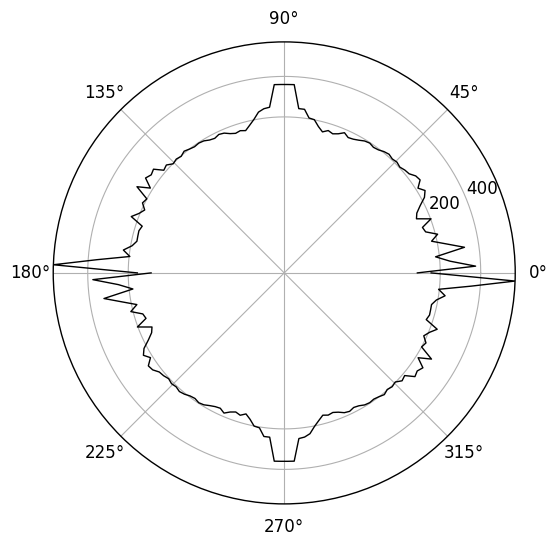

In [164]:
#for ii in range(len(theta)):
#    l = length[ii]
#    th = theta[ii]
#    x = .5*l*np.cos(th/180*np.pi)
#    y = .5*l*np.sin(th/180*np.pi)
#    plt.plot([-x,x],[-y,y])

alpha = np.linspace(0,180,90)
da = alpha[1]-alpha[0]
bin_lo = alpha-da/2

medrad = np.zeros(alpha.shape[0])


for ii in range(len(alpha)):
    bin_indices = np.logical_and(theta_binning>=bin_lo[ii], theta_binning<=bin_lo[ii]+da)
    # let's also introduce a length filter
    medrad[ii] = np.median((length)[np.logical_and(bin_indices,sd_theta>0)])
    # also interesting:
    #medrad[ii] = np.median((length/sd_length)[np.logical_and(bin_indices,length>0)])
    
    
    
#medrad/=pixlen # normalize by length per pixel in that particular direction


# set alpha for plotting
alpha = alpha*np.pi/180
for ii in range(2):
    plt.polar((alpha+ii*np.pi), medrad, color='k')
    

maxrad = np.nanmax(medrad)
minrad = np.nanmin(medrad)

plotrad = np.nanmax(medrad)
plt.xlim((-plotrad,plotrad))
plt.ylim((-plotrad,plotrad))
plt.gca().set_aspect(1)

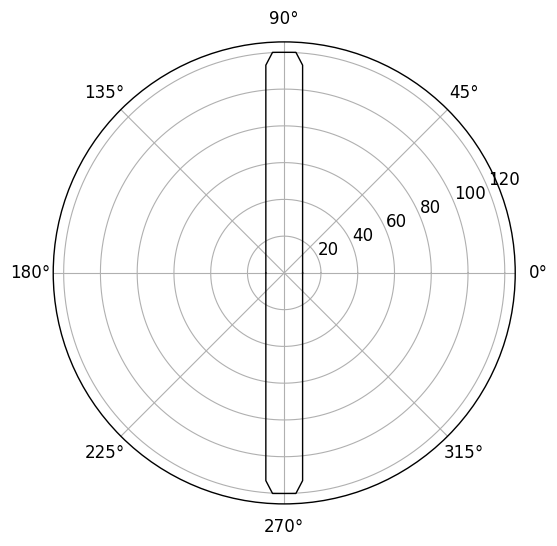

In [165]:
thetacrit = np.arctan(3*bin_AC / (bin_AL))

alpha = np.linspace(0,np.pi,90)

pixlen = np.zeros(alpha.shape)
shortax = np.logical_or(np.abs(alpha)<=thetacrit, np.abs(alpha)>=np.pi-thetacrit)
longax = np.logical_and(np.abs(alpha)>thetacrit, np.abs(alpha)<np.pi-thetacrit)

pixlen[shortax] = 10 * bin_AL / np.cos(np.abs(alpha[shortax]))
pixlen[longax]  = 30 * bin_AC / np.sin(np.abs(alpha[longax]))

pixlen = np.abs(pixlen)


for ii in range(2):
    plt.polar((alpha+ii*np.pi), pixlen, color='k')
    
plt.xlim(-60,60)

... makes sense

# dE/dx

While histograms over individual tracks don't really give good results, how about just using the average dE/dx?

In [166]:
dEdx = np.array(energies)*3.68/length/100/2.32  # Not using depth here

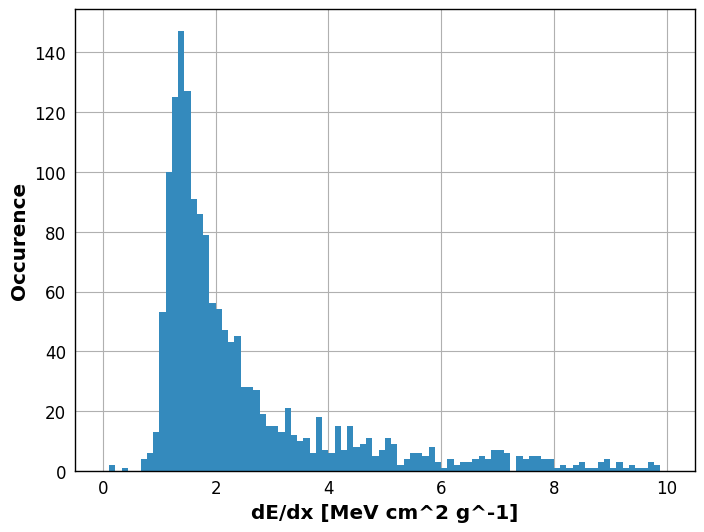

In [177]:
testhist = plt.hist(dEdx[length/sd_length>10],90,log=False,range=(0,10))
#testhist = plt.hist(dEdx,90,log=False,range=(0,20))
#plt.ylim(0,40)
#plt.ylim(0,1700)
#plt.ylim(0,600)
plt.xlabel("dE/dx [MeV cm^2 g^-1]")
plt.ylabel("Occurence")

-> For SM: During quiescence, there is a single peak at about MIP energy. During the flare however, there is a lot of stuff at a higher dE/dX, as you'd expect from lower energy solar particles!

While we're at geometry: What if I histogram, say, the nr. of pixels per tracks vs their energy?

In [120]:
ecos = []
nn = []
lal = []
lac = []

for obs in obslist:
    for ii in range(len(obs.data)):
        nn.append(np.sum(obs.data['TRACK'][ii]>0))
        ecos.append(obs.data['TRACK_EN'][ii])
        lal.append(obs.data['DIM_AL'][ii])
        lac.append(obs.data['DIM_AC'][ii])

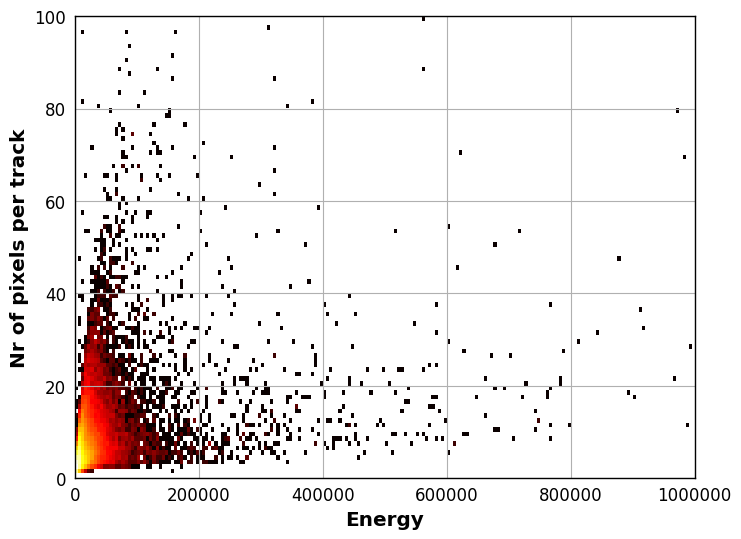

In [121]:
testhist = plt.hist2d(ecos,nn,bins=(200,100),cmap='hot',range=[[0,1000000],[0,100]],norm=LogNorm())
plt.xlabel('Energy')
plt.ylabel('Nr of pixels per track')

Try to (efficiently) generate 2D images to play with

In [15]:
def tracksim(length, theta, start, pixratio, dims):
    
    # create an output image
    outimg = np.zeros(dims)
    
    # test if start and stop are inside the array?
    
    # line equation y = m*x + b
    theta_rad = theta*np.pi/180
    m = np.tan(theta_rad) / pixratio  # need to correct by the pixel factor
    b = start[1]-start[0]*m
    
    
    # distance crossed in x and y (pixels!)
    dx = length*np.cos(theta_rad)
    dy = length*np.sin(theta_rad)/pixratio
    
    # depending on which distance is higher, prepare a few points of that in advance
    # then apply the line function to it
    
    
    if np.abs(dx)>=np.abs(dy):
        stop_x = start[0] + dx
        fillx = np.arange(start[0],stop_x,0.1*np.sign(dx))
        filly = m*fillx + b
    else:
        stop_y = start[1] + dy
        filly = np.arange(start[1],stop_y,0.1*np.sign(dy))
        fillx = (filly-b)/m

    # floor, for indices
    fillx = np.floor(fillx).astype(int)
    filly = np.floor(filly).astype(int)
    
    # select only values in bounds of image, and set them to 1
    in_bounds = (fillx>-1)*(fillx<dims[0])*(filly>-1)*(filly<dims[1])
    outimg[(fillx[in_bounds],filly[in_bounds])] = 1
    
    return outimg

45.4959448923 4.71781842932
21.3992317725 2.74940540703


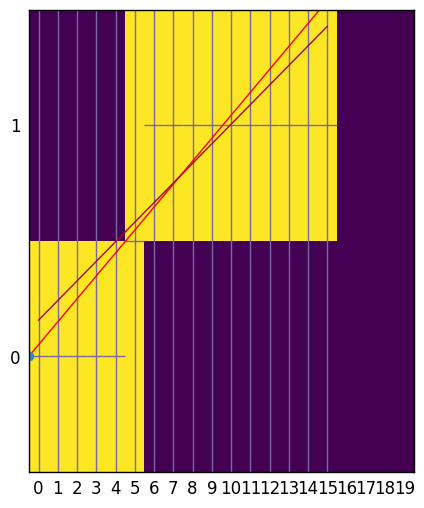

In [37]:
length = 140
angle = 50
start = (0,0.5)
pixfactor = 12
dims = (20,2)

theta_rad = angle*np.pi/180
m = np.tan(theta_rad) / pixfactor  # need to correct by the pixel factor
b = start[1]-start[0]*m
x = np.linspace(0,dims[0])

plt.plot(x-0.5,m*x+b-0.5,color='r')
plt.plot(start[0]-0.5,start[1]-0.5,marker='o')

mytrack = tracksim(length, angle, start, pixfactor, dims)
angle_linefit_show(mytrack,pixratio=12)
plt.imshow((np.transpose(mytrack)),origin='lower',aspect=pixfactor)
ax = plt.gca()
ax.set_xticks(range(dims[0]))
ax.set_yticks(range(dims[1]))
plt.grid(False)